In [124]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from scipy.sparse import csr_matrix
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import cluster

In [29]:
dataRuspini = pd.read_csv('ruspini.csv', sep=',')
dataFood = pd.read_csv('food.csv', sep=';')

In [16]:
X= dataFood.values[:,1:]
X_scaled = StandardScaler().fit_transform(X)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fafbf475f28>,
 'caps': [<matplotlib.lines.Line2D at 0x7fafbf406668>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fafbf475dd8>,
 'medians': [<matplotlib.lines.Line2D at 0x7fafbf406cf8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fafbf411080>,
 'means': []}

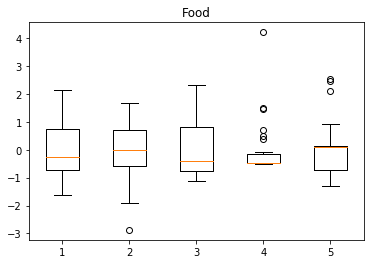

In [20]:
fig1, ax1 = plt.subplots()
ax1.set_title('Food')
ax1.boxplot(X_scaled)

1.Load and describe the 2 datasets into R. Thanks to boxplots, try to highlight some outliers, if any.

After the normalization of the dataset food , we find that for the last two features, there are some outliers.  

Text(0.5, 1.0, 'Raw data')

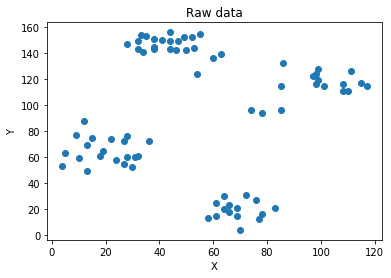

In [36]:
plt.scatter(dataRuspini.values[:,1],dataRuspini.values[:,2])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Raw data')

2.Plot the data in a 2D space. What can you say about the structure of the data? How many cluster do you expect to be found by the clustering algorithms? 

From the image, we can interpret that all the instances can be classified into four clusters.   

Text(0.5, 1.0, 'Clusters4_1')

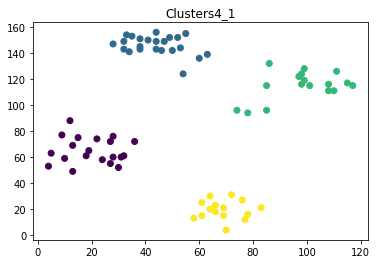

In [56]:
kmeans = KMeans(n_clusters=4).fit(dataRuspini.values[:,1:])
plt.scatter(dataRuspini.values[:,1], dataRuspini.values[:,2], c=kmeans.labels_)
plt.title("Clusters4_1")

Text(0.5, 1.0, 'Clusters4_2')

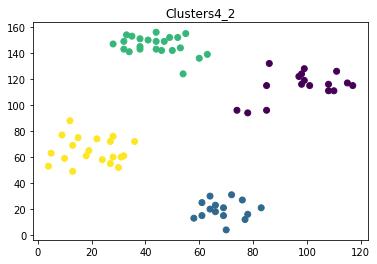

In [57]:
kmeans_1 = KMeans(n_clusters=4).fit(dataRuspini.values[:,1:])
plt.scatter(dataRuspini.values[:,1], dataRuspini.values[:,2], c=kmeans_1.labels_)
plt.title("Clusters4_2")

3.Run a k-means algorithm with a given number of clusters. Plot the ruspini data set and assign to each point a specific color according to its group. Repeat the same operation several times while vizualizing the results. What do you remark ?

We assign the number of clusters as 4 at the beginning and even after serveral repeats we find that the result is quite stable. We think that because we have choosen a good number of cluster so the result is the same. If the number is too large as we do below like 10 e.g., the clusters won't be stable.

4.Try to tune some parameters found in help(kmeans) in order to fix the issue seen before

As we have already saw the distribution of the dataset, so we choose 4 and it's adapted for this case so we didn't have any unstable issue.

Text(0.5, 1.0, 'Clusters10_1')

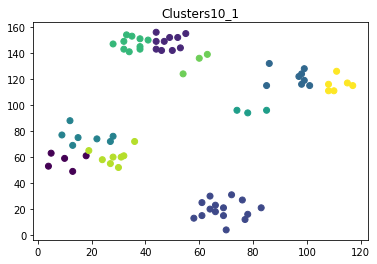

In [67]:
kmeans_3 = KMeans(n_clusters=10).fit(dataRuspini.values[:,1:])
plt.scatter(dataRuspini.values[:,1], dataRuspini.values[:,2], c=kmeans_3.labels_)
plt.title("Clusters10_1")

Text(0.5, 1.0, 'Clusters10_2')

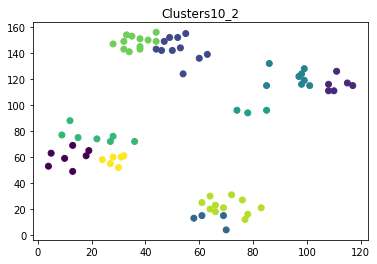

In [61]:
kmeans_4 = KMeans(n_clusters=10).fit(dataRuspini.values[:,1:])
plt.scatter(dataRuspini.values[:,1], dataRuspini.values[:,2], c=kmeans_4.labels_)
plt.title("Clusters10_2")

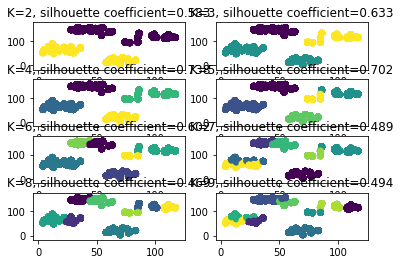

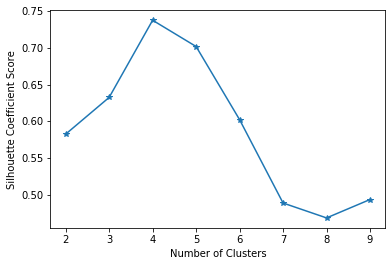

In [83]:
clusters = range(2,10)                                   
subplot_counter = 0
sc_scores = []
for t in clusters:
    subplot_counter += 1
    plt.subplot(4,2,subplot_counter)
    kmeans_model = KMeans(n_clusters=t).fit(dataRuspini.values[:,1:])          #训练模型
    for i,l in enumerate(kmeans_model.labels_):
        plt.scatter(dataRuspini.values[:,1], dataRuspini.values[:,2], c = kmeans_model.labels_)
    sc_score = silhouette_score(dataRuspini.values[:,1:], kmeans_model.labels_, metric='euclidean')
    sc_scores.append(sc_score)
    plt.title('K=%s, silhouette coefficient=%0.03f'%(t,sc_score))
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()

5.You are asked to writea code that will compute the silhouette for a k-means clustering of the Ruspini dataset with a ini-tial number of clusters ranging from 2 to 10. Plot the evolution of the silhouette index against theinitial number of clusters. What is your conclusion ?

According to the silhouette index, we find that when the number of clusters equals 4, we get the highest silhouette coefficient score, which corresponds to our previous result. 

In [86]:
class KMedoids:
    def __init__(self, n_cluster=2, max_iter=10, tol=0.1, start_prob=0.8, end_prob=0.99):
        '''Kmedoids constructor called'''
        if start_prob < 0 or start_prob >= 1 or end_prob < 0 or end_prob >= 1 or start_prob > end_prob:
            raise ValueError('Invalid input')
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.tol = tol
        self.start_prob = start_prob
        self.end_prob = end_prob
        
        self.medoids = []
        self.clusters = {}
        self.tol_reached = float('inf')
        self.current_distance = 0
        
        self.__data = None
        self.__is_csr = None
        self.__rows = 0
        self.__columns = 0
        self.cluster_distances = {}
        
        
    def fit(self, data):
        self.__data = data
        self.__set_data_type()     
        self.__start_algo()
        return self
    
    def __start_algo(self):
        self.__initialize_medoids()
        self.clusters, self.cluster_distances = self.__calculate_clusters(self.medoids)
        self.__update_clusters()
 
    def __update_clusters(self):
        for i in range(self.max_iter):
            cluster_dist_with_new_medoids = self.__swap_and_recalculate_clusters()
            if self.__is_new_cluster_dist_small(cluster_dist_with_new_medoids) == True:
                self.clusters, self.cluster_distances = self.__calculate_clusters(self.medoids)
            else:
                break

    def __is_new_cluster_dist_small(self, cluster_dist_with_new_medoids):
        existance_dist = self.calculate_distance_of_clusters()
        new_dist = self.calculate_distance_of_clusters(cluster_dist_with_new_medoids)
        
        if existance_dist > new_dist and (existance_dist - new_dist) > self.tol:
            self.medoids = cluster_dist_with_new_medoids.keys()
            return True
        return False
    
    def calculate_distance_of_clusters(self, cluster_dist=None):
        if cluster_dist == None:
            cluster_dist = self.cluster_distances
        dist = 0
        for medoid in cluster_dist.keys():
            dist += cluster_dist[medoid]
        return dist
        
    def __swap_and_recalculate_clusters(self):
        # http://www.math.le.ac.uk/people/ag153/homepage/KmeansKmedoids/Kmeans_Kmedoids.html
        cluster_dist = {}
        for medoid in self.medoids:
            is_shortest_medoid_found = False
            for data_index in self.clusters[medoid]:
                if data_index != medoid:
                    cluster_list = list(self.clusters[medoid])
                    cluster_list[self.clusters[medoid].index(data_index)] = medoid
                    new_distance = self.calculate_inter_cluster_distance(data_index, cluster_list)
                    if new_distance < self.cluster_distances[medoid]:
                        cluster_dist[data_index] = new_distance
                        is_shortest_medoid_found = True
                        break
            if is_shortest_medoid_found == False:
                cluster_dist[medoid] = self.cluster_distances[medoid]
        return cluster_dist
    
    def calculate_inter_cluster_distance(self, medoid, cluster_list):
        distance = 0
        for data_index in cluster_list:
            distance += self.__get_distance(medoid, data_index)
        return distance/len(cluster_list)
        
    def __calculate_clusters(self, medoids):
        clusters = {}
        cluster_distances = {}
        for medoid in medoids:
            clusters[medoid] = []
            cluster_distances[medoid] = 0
            
        for row in range(self.__rows):
            nearest_medoid, nearest_distance = self.__get_shortest_distance_to_mediod(row, medoids)
            cluster_distances[nearest_medoid] += nearest_distance
            clusters[nearest_medoid].append(row)
        
        for medoid in medoids:
            cluster_distances[medoid] /= len(clusters[medoid])
        return clusters, cluster_distances
        
        
    def __get_shortest_distance_to_mediod(self, row_index, medoids):
        min_distance = float('inf')
        current_medoid = None
        
        for medoid in medoids:
            current_distance = self.__get_distance(medoid, row_index)
            if current_distance < min_distance:
                min_distance = current_distance
                current_medoid = medoid
        return current_medoid, min_distance

    def __initialize_medoids(self):
        '''Kmeans++ initialisation'''
        self.medoids.append(random.randint(0,self.__rows-1))
        while len(self.medoids) != self.n_cluster:
            self.medoids.append(self.__find_distant_medoid())
    
    def __find_distant_medoid(self):
        distances = []
        indices = []
        for row in range(self.__rows):
            indices.append(row)
            distances.append(self.__get_shortest_distance_to_mediod(row,self.medoids)[1])
        distances_index = np.argsort(distances)
        choosen_dist = self.__select_distant_medoid(distances_index)
        return indices[choosen_dist]
    
    def __select_distant_medoid(self, distances_index):
        start_index = round(self.start_prob*len(distances_index))
        end_index = round(self.end_prob*(len(distances_index)-1)) 
        return distances_index[random.randint(start_index, end_index)]

                           
    def __get_distance(self, x1, x2):
        a = self.__data[x1].toarray() if self.__is_csr == True else np.array(self.__data[x1])
        b = self.__data[x2].toarray() if self.__is_csr == True else np.array(self.__data[x2])
        return np.linalg.norm(a-b)
    
    def __set_data_type(self):
        '''to check whether the given input is of type "list" or "csr" '''
        if isinstance(self.__data,csr_matrix):
            self.__is_csr = True
            self.__rows = self.__data.shape[0]
            self.__columns = self.__data.shape[1]
        elif isinstance(self.__data,list):
            self.__is_csr = False
            self.__rows = len(self.__data)
            self.__columns = len(self.__data[0])
        else:
            raise ValueError('Invalid input')

In [91]:
def plot_graphs(data, k_medoids):
    colors = {0:'b*', 1:'g^',2:'ro',3:'c*', 4:'m^', 5:'yo', 6:'ko', 7:'w*'}
    index = 0
    for key in k_medoids.clusters.keys():
        temp_data = k_medoids.clusters[key]
        x = [data[i][0] for i in temp_data]
        y = [data[i][1] for i in temp_data]
        plt.plot(x, y, colors[index])
        index += 1
    plt.title('Cluster formations')
    plt.show()

    medoid_data_points = []
    for m in k_medoids.medoids:
        medoid_data_points.append(data[m])   
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    x_ = [i[0] for i in medoid_data_points]
    y_ = [i[1] for i in medoid_data_points]
    plt.plot(x, y, 'yo')
    plt.plot(x_, y_, 'r*')
    plt.title('Mediods are highlighted in red')
    plt.show()

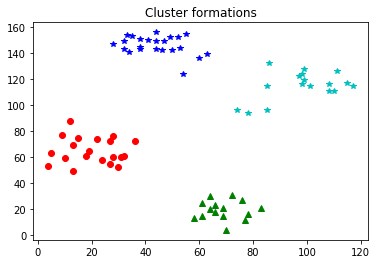

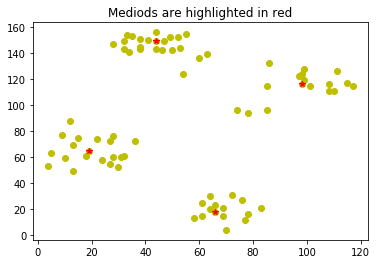

In [93]:
k_medoids = KMedoids(n_cluster=4)
k_medoids.fit(list(dataRuspini.values[:,1:]))
plot_graphs(list(dataRuspini.values[:,1:]), k_medoids);

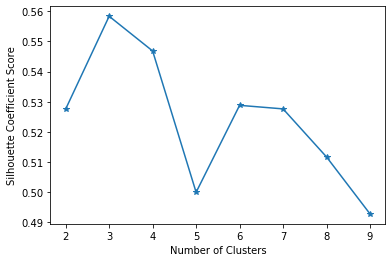

In [100]:
clusters = range(2,10)                                   
sc_scores = []
for t in clusters:
    kmeans_model = KMeans(n_clusters=t).fit(dataFood.values[:,1:])          
    sc_score = silhouette_score(dataFood.values[:,1:], kmeans_model.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()

7.Have a first look at this dataset and try to make a partitional algorithm procedure like before.

By calculating the silhouette coefficient score of different number of clusters, we find that when the number of cluster is set to three, these datas can be well classfied.  

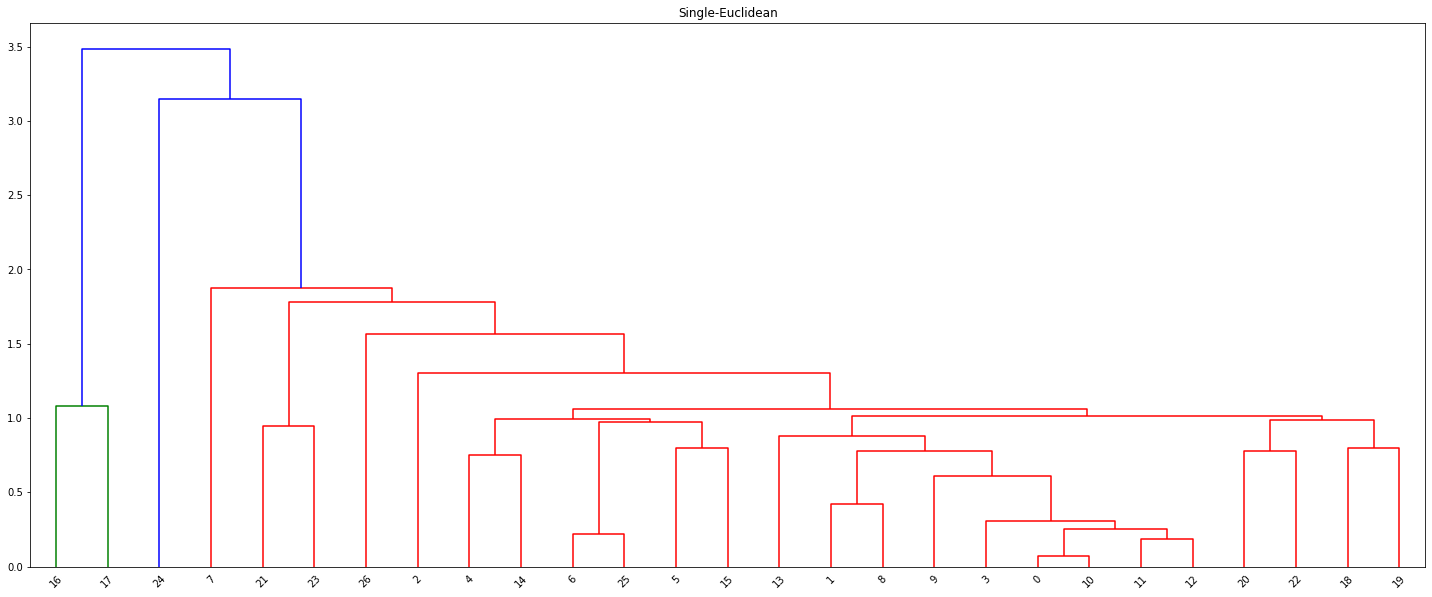

In [122]:
infoFood = StandardScaler().fit_transform(dataFood.values[:,1:])
Z = linkage(infoFood, 'single')
fig = plt.figure(figsize=(25, 10))
plt.title('Single-Euclidean')
dn = dendrogram(Z)

8.Perform a hierarchical clustering by first standardizing the colums of interest, then computing a dissimilarity between the objects, and finally running an agglomerative algorithm to yield a dendrogram. Interpret the results.

According to the dendrogram, we observe that all instances are seperated into three groupes.

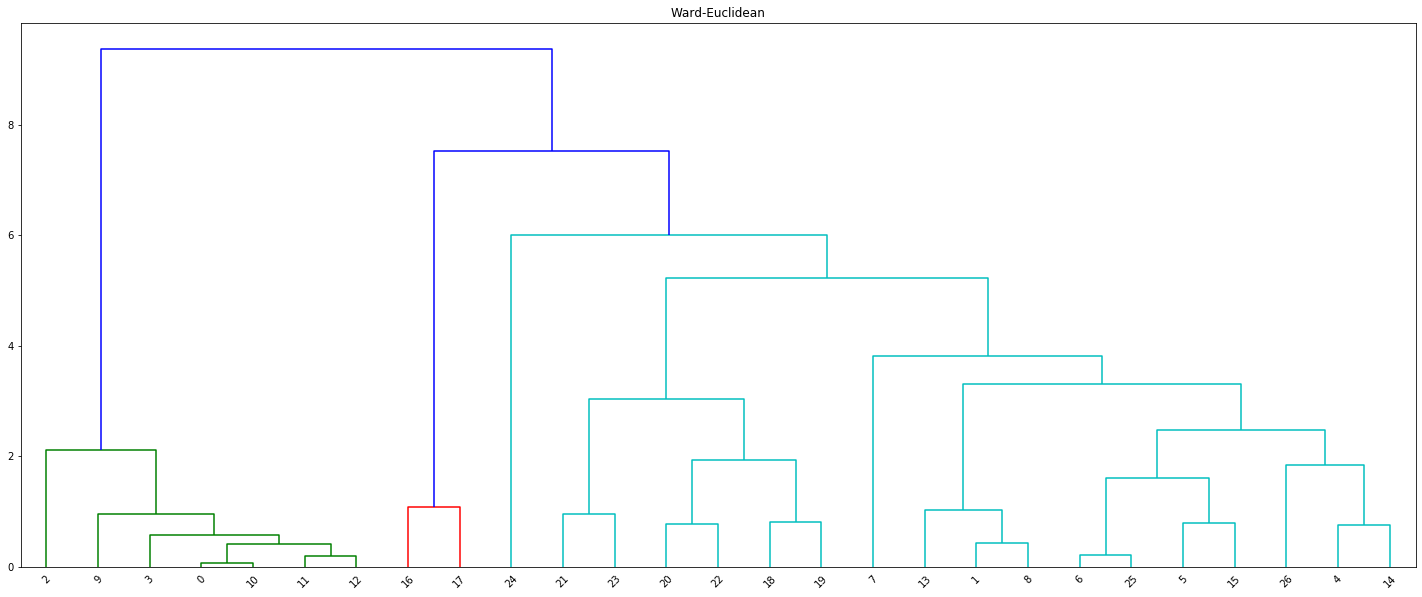

In [121]:
infoFood = StandardScaler().fit_transform(dataFood.values[:,1:])
Z = linkage(infoFood, 'ward', metric='euclidean')
fig = plt.figure(figsize=(25, 10))
plt.title('Ward-Euclidean')
dn = dendrogram(Z)

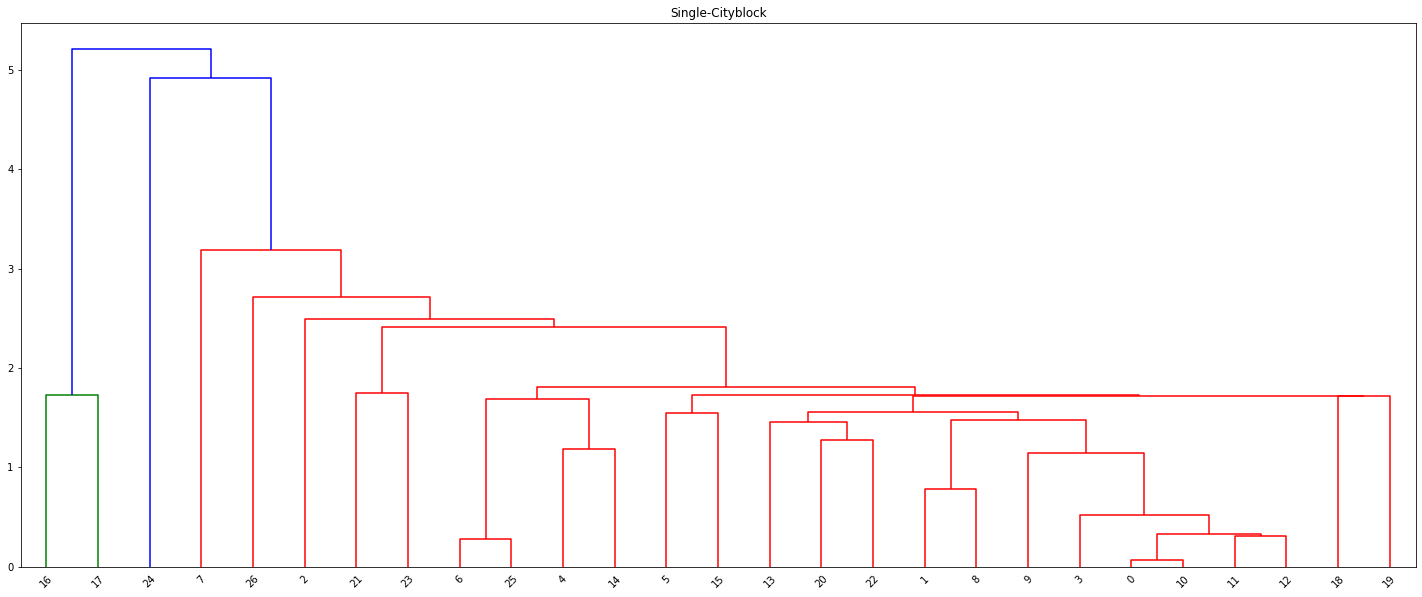

In [120]:
infoFood = StandardScaler().fit_transform(dataFood.values[:,1:])
Z = linkage(infoFood, 'single', metric='cityblock')
fig = plt.figure(figsize=(25, 10))
plt.title('Single-Cityblock')
dn = dendrogram(Z)

9.Try to hightlight the impact of the chosen distance on the results. Next, try to show the impactof the agglomerative criteria on the results

From the three images aboves, we conclude that if using different dictance metrics, intra-grouping will be different, but globaly, the three big cluster have the same content, if we change the agglomerative criteria, we can also see a change even in the inter-level, the components of three clusters have changed a lot.     


In [148]:
infoFood = StandardScaler().fit_transform(dataFood.values[:,1:])
Z = linkage(infoFood, 'ward', metric='euclidean')
cutree = cluster.hierarchy.cut_tree(Z, height=3)
print(cutree)

[[0]
 [1]
 [0]
 [0]
 [2]
 [2]
 [2]
 [3]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [2]
 [2]
 [4]
 [4]
 [5]
 [5]
 [5]
 [6]
 [5]
 [6]
 [7]
 [2]
 [2]]
